# Multi-armed Portfolio Bandit


This notebook is the core of our Multi-armed Bandit (MAB) analysis. 
The notebooks is seperated into different sections five sections:

*   **Setup** - Set the correct file path

*   **Class Structure** - The Multi-armed POrtfolio Bandit Framework

*   **Data Preparation** - Data preprocessing and final dataframe creation

*   **Model Analysis** - Comparing performance of underlying supervised models

*   **Multi-armed Bandit Experiment** - Conducting the MAB experiments with different configuarionts 


The accompanying blog post for this analysis can be found [here](https://github.com/vbUmich/Multi-armed-Portfolio-Bandit).

# Setup

Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import OneHotEncoder

Change to Appropriate Path

In [ ]:
path = 'PATH_TO_DATA'

# Class Structure

## Bandit

In [ ]:
#Setting the 'reward_type' to 'pl' produces a standard profit & loss return, otherwise a the class produces a sharpe-based reward, on a weekly basis
#The sharpe-based approach penalizes the reward based on the risk taken
#The calculation involves the ex-ante standard deviation of the underlying portfolio that the supervised strategy uses at each point in time
#The sharpe-based method uses long-term history of variance and covariance of both funds

class MAB_WeeklyReturnsStdevs(object):
    def __init__(self, weekly_returns, weekly_signals, reward_type = 'pl') -> None:
        self.action_counts = 5
        self.action_values = weekly_returns
        self.action_std = weekly_signals.apply(lambda action: np.sqrt((0.024**2) * (0.6 + 0.1*action)**2 + (0.009**2) * (0.6 - 0.1*action)**2 - 2*(0.6 + 0.1*action)*(0.6 - 0.1*action)*0.000075))
        self.reward_type = reward_type

    def reset(self):
        None

    def get_action(self, action, trial):
        if self.reward_type == 'pl':
          rewards = self.action_values.iloc[trial]
          action_index = action

        else:
          rewards = self.action_values.iloc[trial] / self.action_std.iloc[trial].values
          action_index = action
        
        returns = self.action_values.iloc[trial]
        return (rewards, returns, action_index)

## Agent

In [ ]:
class MAB_Agent(object):

    def __init__(self, MAB, MAB_policy, prior = 0, gamma=None) -> None:
        self.action_counts = MAB.action_counts
        self.MAB_policy = MAB_policy
        self.time_step = 0
        self.prev_action = None
        self.past_actions = []
        self.past_actions_tally = None
        self.prior = prior
        self.reward_estimates = prior * np.ones(self.action_counts)
        self.past_rewards = np.zeros((self.action_counts, self.action_counts))

    def reset(self):
        self.time_step = 0
        self.prev_action = None
        self.past_action = []
        self.past_actions_tally = None
        self.reward_estimates = self.prior * np.ones(self.action_counts)
        self.past_rewards = np.zeros((self.action_counts, self.action_counts))

    def select_action(self):
        selected_action = self.MAB_policy.choose_action(self)
        self.prev_action = selected_action
        self.past_actions.append(selected_action)

        action_tally =  np.zeros(self.action_counts)
        action_tally[selected_action] = 1

        if self.past_actions_tally is None:
          self.past_actions_tally = action_tally
        else:
          self.past_actions_tally = np.vstack([self.past_actions_tally, action_tally])

        return selected_action

    def eval_step(self, rewards):
        self.past_rewards = np.vstack([self.past_rewards, rewards])
        self.reward_estimates[:] = self.past_rewards.mean(axis = 0)
        self.time_step += 1

## Policies

In [ ]:
class epsilonGreedy(object):
    def __init__(self, epsilon) -> None:
        self.epsilon = epsilon
        self.name = 'Epsilon-Greedy'

    def update_epsilon(self, epsilon):
      self.epsilon = epsilon

    def choose_action(self, agent):

        if np.random.random() < self.epsilon:
            return np.random.choice(agent.action_counts)
        else:
            selected_action = np.argmax(agent.reward_estimates)
            check = np.where(agent.reward_estimates == agent.reward_estimates[selected_action])[0]

            if len(check) == 1:
                return selected_action
            else:
                return np.random.choice(check)

class epsilonGreedyDecay(object):
    def __init__(self, epsilon, min_epsilon, epsilon_decay) -> None:
        self.epsilon = epsilon
        self.original_epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.name = 'Decayed Epsilon-Greedy'

    def update_epsilon(self, epsilon):
      self.epsilon = epsilon

    def choose_action(self, agent):

        if self.epsilon > self.min_epsilon:
          self.epsilon *= self.epsilon_decay

        if np.random.random() < self.epsilon:
            return np.random.choice(agent.action_counts)
        else:
            selected_action = np.argmax(agent.reward_estimates)
            check = np.where(agent.reward_estimates == agent.reward_estimates[selected_action])[0]

            if len(check) == 1:
                return selected_action
            else:
                return np.random.choice(check)

class NSepsilonGreedy(object):
    def __init__(self, epsilon, buffer) -> None:
        self.epsilon = epsilon
        self.buffer = buffer
        self.name = 'Non-stationary Epsilon-Greedy'

    def update_epsilon(self, epsilon):
      self.epsilon = epsilon

    def choose_action(self, agent):

        if np.random.random() < self.epsilon:
            return np.random.choice(agent.action_counts)
        else:
            selected_action = np.argmax(agent.past_rewards[-self.buffer:,:].mean(axis = 0))
            check = np.where(agent.reward_estimates == agent.reward_estimates[selected_action])[0]

            if len(check) == 1:
                return selected_action
            else:
                return np.random.choice(check)

class NSDepsilonGreedy(object):
    def __init__(self, epsilon, buffer) -> None:
        self.epsilon = epsilon
        self.buffer = buffer
        self.name = 'Non-stationary EWM Epsilon-Greedy'

    def update_epsilon(self, epsilon):
      self.epsilon = epsilon

    def choose_action(self, agent):
        if np.random.random() < self.epsilon:
            return np.random.choice(agent.action_counts)
        else:
            reward_history = pd.DataFrame(agent.past_rewards)
            selected_action = np.argmax(reward_history.ewm(halflife = self.buffer).mean().iloc[-1])
            check = np.where(agent.reward_estimates == agent.reward_estimates[selected_action])[0]

            if len(check) == 1:
                return selected_action
            else:
                return np.random.choice(check)

## Environment

In [ ]:
class MAB_environment_sharpe(object):
    def __init__(self, MAB, MAB_agent, supervised_signals, portfolio, reward_type = 'pl') -> None:
        self.MAB = MAB
        self.MAB_agent = MAB_agent
        self.supervised_signals = supervised_signals
        self.portfolio = portfolio
        self.reward_type = reward_type

    def reset(self):
        self.MAB.reset()
        self.MAB_agent.reset()
        
    def run(self, n_trials=100, n_experiments=1):
        rewards_t = np.zeros(n_trials)
        returns_t = np.zeros(n_trials)

        rewards_history = np.zeros((n_trials, self.MAB.action_counts))
        returns_history = np.zeros((n_trials, self.MAB.action_counts))

        weighted_action_history = np.zeros((n_trials, self.MAB.action_counts))
        
        for _ in range(n_experiments):
            self.reset()

            for trial in range(n_trials):
            
                rewards, returns, action_index = self.MAB.get_action(self.MAB_agent.select_action(), trial)

                # Create Fifth Arm Reward
                ################################
                new_arm_trial = trial-1

                while self.MAB_agent.past_actions[new_arm_trial] == (self.MAB.action_counts - 1) and new_arm_trial > 0:
                  new_arm_trial = new_arm_trial - 1

                if new_arm_trial <= 0:
                  last_model_action = 0
                else:
                  last_model_action = self.supervised_signals.iloc[new_arm_trial,self.MAB_agent.past_actions[new_arm_trial]]

                self.portfolio.change_allocation(last_model_action)

                date_plus_week = np.datetime64((pd.to_datetime(self.supervised_signals.index.values[trial]) + dt.timedelta(days=7)).to_pydatetime().date())

                returns['naive_momentum'] = ((self.portfolio.current_allocation[0] * fund_weekly_returns.loc[date_plus_week][self.portfolio.fund_names[0]]) + (self.portfolio.current_allocation[1] * fund_weekly_returns.loc[date_plus_week][self.portfolio.fund_names[1]]))
                
                if self.reward_type == 'pl':
                    rewards['naive_momentum'] = returns['naive_momentum']
                else:
                    rewards['naive_momentum'] = returns['naive_momentum'] / np.sqrt((0.024**2) * (0.6 + 0.1*last_model_action)**2 + (0.009**2) * (0.6 - 0.1*last_model_action)**2 - 2*(0.6 + 0.1*last_model_action)*(0.6 - 0.1*last_model_action)*0.000075)
                ################################

                self.MAB_agent.eval_step(rewards)

                rewards_t[trial] += rewards[action_index]
                returns_t[trial] += returns[action_index]

                rewards_history[trial] += rewards
                returns_history[trial] += returns
                
            weighted_action_history += self.MAB_agent.past_actions_tally

        return rewards_t / n_experiments, returns_t / n_experiments, rewards_history / n_experiments, returns_history / n_experiments, weighted_action_history / n_experiments

## Portfolio

In [ ]:
class two_fund_portfolio(object):
    
    def __init__(self, initial_allocation, allocation_change) -> None:
        self.fund_names = ['iShares 7-10 Year Treasury Bond ETF', 'iShares S&P 500 Index Fund']
        self.num_funds = 2
        self.initial_allocation = initial_allocation
        self.current_allocation = initial_allocation
        self.allocation_change = allocation_change
        self.transaction_fee = [0, 0]

    def reset(self):
      self.current_allocation = self.initial_allocation
    
    def change_allocation(self, signal):
        if signal == 1:
            self.current_allocation = [self.initial_allocation[0] - self.allocation_change, self.initial_allocation[1] + self.allocation_change]
        elif signal == -1:
            self.current_allocation = [self.initial_allocation[0] + self.allocation_change, self.initial_allocation[1] - self.allocation_change]
        elif signal == 0:
            self.current_allocation = self.initial_allocation

# Data Preparation

## Get Weekly Fund Returns

In [ ]:
fund_weekly_returns = pd.read_csv(path + '/CRSP/selectedFundWeeklyReturns.csv', sep='\t', index_col='caldt')
fund_weekly_returns.index = pd.to_datetime(fund_weekly_returns.index)

#Select returns for testing period
fund_weekly_returns = fund_weekly_returns.loc['2016-07-01':'2020-12-31']

Fund Returns throughout Testing Period

In [ ]:
fund_weekly_returns[fund_weekly_returns.columns].sum()

iShares 7-10 Year Treasury Bond ETF    0.154491
iShares S&P 500 Index Fund             0.772762
dtype: float64

## Static Portfolio Returns

In [ ]:
def get_cummulative_portfolio_returns(returns_df, asset_mix):
  cummulative_return = 0

  for index, asset_mix_percentage in enumerate(asset_mix):
    cummulative_return += returns_df[returns_df.columns].sum()[index] * asset_mix[index]

  return cummulative_return

In [ ]:
tr_alloc4060 = get_cummulative_portfolio_returns(fund_weekly_returns, [0.60, 0.40])
print('Static allocation returns of a 60% fixed income and 40% equity portfolio: ' + str(round(tr_alloc4060, 6)))

tr_alloc5050 = get_cummulative_portfolio_returns(fund_weekly_returns, [0.50, 0.50])
print('Static allocation returns of a 50% fixed income and 50% equity portfolio: ' + str(round(tr_alloc5050, 6)))

tr_alloc6040 = get_cummulative_portfolio_returns(fund_weekly_returns, [0.40, 0.60])
print('Static allocation returns of a 40% fixed income and 60% equity portfolio: ' + str(round(tr_alloc6040, 6)))

tr_alloc7030 = get_cummulative_portfolio_returns(fund_weekly_returns, [0.30, 0.70])
print('Static allocation returns of a 30% fixed income and 70% equity portfolio: ' + str(round(tr_alloc7030, 6)))

Static allocation returns of a 60% fixed income and 40% equity portfolio: 0.401799
Static allocation returns of a 50% fixed income and 50% equity portfolio: 0.463626
Static allocation returns of a 40% fixed income and 60% equity portfolio: 0.525454
Static allocation returns of a 30% fixed income and 70% equity portfolio: 0.587281


## Supervised Model Signals

In [ ]:
supervised_1_signals = pd.read_csv(path + 'supervisedmodel1.csv', sep='\t', index_col=[0])
supervised_1_signals.columns = ['supervised_1_signal']

supervised_2_signals = pd.read_csv(path + 'supervisedmodel2.csv', sep='\t', index_col=[0])
supervised_2_signals.columns = ['supervised_2_signal']

supervised_static_60_40_signals = supervised_2_signals.copy()
supervised_static_60_40_signals[:] = 0
supervised_static_60_40_signals.columns = ['static_60_40_signal']

supervised_perfect_foresight_20_signals = pd.read_csv(path + 'perfect_foresight_signals/foresight_20_signal.csv', sep='\t', index_col=[0])
supervised_perfect_foresight_20_signals.columns = ['perfect_foresight_20_signal']

supervised_signals = pd.concat([supervised_1_signals, supervised_2_signals, supervised_static_60_40_signals, supervised_perfect_foresight_20_signals], axis = 1)
supervised_signals.index = pd.to_datetime(supervised_signals.index)
supervised_signals = supervised_signals.loc['2016-07-01':'2020-12-31']

In [ ]:
print(supervised_signals['supervised_1_signal'].value_counts())

 1.0    136
-1.0     61
 0.0     38
Name: supervised_1_signal, dtype: int64


In [ ]:
print(supervised_signals['supervised_2_signal'].value_counts())

 0.0    123
 1.0     92
-1.0     20
Name: supervised_2_signal, dtype: int64


In [ ]:
print(supervised_signals['static_60_40_signal'].value_counts())

0.0    235
Name: static_60_40_signal, dtype: int64


In [ ]:
print(supervised_signals['perfect_foresight_20_signal'].value_counts())

 0.0    87
 1.0    82
-1.0    66
Name: perfect_foresight_20_signal, dtype: int64


## Two Fund Portfolio Returns

In [ ]:
tf_portfolio = two_fund_portfolio([0.40, 0.60], 0.10)

fixed_fund_name = tf_portfolio.fund_names[0]
equity_fund_name = tf_portfolio.fund_names[1]

print(fixed_fund_name)
print(equity_fund_name)

iShares 7-10 Year Treasury Bond ETF
iShares S&P 500 Index Fund


In [ ]:
def getNextPeriodPortfolioReturns(portfolio, model_signal, date_plus_week):

  portfolio.change_allocation(model_signal) 
  
  return (portfolio.current_allocation[0] * fund_weekly_returns.loc[date_plus_week][fixed_fund_name]) + (portfolio.current_allocation[1] * fund_weekly_returns.loc[date_plus_week][equity_fund_name])


In [ ]:
#Calculate portfolio returns
portfolio_returns = pd.DataFrame(columns=['supervised_1', 'supervised_2', 'static_60_40', 'perfect_foresight_20'])

for date, row in supervised_signals[:-1].iterrows():

    date_plus_week = pd.to_datetime(date + dt.timedelta(days=7))

    supervised_1_returns = getNextPeriodPortfolioReturns(tf_portfolio, row['supervised_1_signal'], date_plus_week)
    supervised_2_returns = getNextPeriodPortfolioReturns(tf_portfolio, row['supervised_2_signal'], date_plus_week)
    static_60_40_returns = getNextPeriodPortfolioReturns(tf_portfolio, row['static_60_40_signal'], date_plus_week)
    perfect_foresight_20_returns = getNextPeriodPortfolioReturns(tf_portfolio, row['perfect_foresight_20_signal'], date_plus_week)

    portfolio_returns.loc[date] = [supervised_1_returns, supervised_2_returns, static_60_40_returns, perfect_foresight_20_returns]

portfolio_returns.sum()

supervised_1            0.574676
supervised_2            0.546786
static_60_40            0.502347
perfect_foresight_20    0.558959
dtype: float64

#Model Analysis

## Model Comparison

In [ ]:
policy_comparison_df = pd.DataFrame(columns=['Model', 'Return', 'Standard Deviation', 'Sharpe Ratio'])

for model in portfolio_returns.columns:
  return_sum = sum(portfolio_returns[model])
  return_std = np.std(portfolio_returns[model])
  
  df_entry = {'Model': model, 'Return': return_sum, 'Standard Deviation': return_std, 'Sharpe Ratio': return_sum/return_std}

  policy_comparison_df = policy_comparison_df.append(df_entry, ignore_index=True)

policy_comparison_df

Model    Return  Standard Deviation  Sharpe Ratio
0          supervised_1  0.574676            0.016531     34.764409
1          supervised_2  0.546786            0.016055     34.056599
2          static_60_40  0.502347            0.014769     34.013033
3  perfect_foresight_20  0.558959            0.014145     39.516274

## Bias-corrected Comparison - Supervised Model 1

In [ ]:
base_comparison_1 = pd.DataFrame({'supervised_1_signal': [tr_alloc5050, tr_alloc6040, tr_alloc7030]}, index = [-1, 0, 1])

print('Strategy 1 Bias-corrected Equivalent Return')

Strategy 1 Bias-corrected Equivalent Return


In [ ]:
bias1 = supervised_signals['supervised_1_signal'].value_counts()/len(supervised_signals)

print(f"Net Long Bias of Strategy 1: {supervised_signals['supervised_1_signal'].sum()/len(supervised_signals)}\n")

print(f"Equivalent Bias Static Return: {(bias1.to_frame()*base_comparison_1).sum().values[0]}")

Net Long Bias of Strategy 1: 0.3191489361702128

Equivalent Bias Static Return: 0.5451856531914883


## Bias-corrected Comparison - Supervised Model 2

In [ ]:
base_comparison_2 = pd.DataFrame({'supervised_2_signal': [tr_alloc5050, tr_alloc6040, tr_alloc7030]}, index = [-1, 0, 1])
print('Strategy 2 Bias-corrected Equivalent Return')

Strategy 2 Bias-corrected Equivalent Return


In [ ]:
bias2 = supervised_signals['supervised_2_signal'].value_counts()/len(supervised_signals)

print(f"Net Long Bias of Strategy 2: {supervised_signals['supervised_2_signal'].sum()/len(supervised_signals)}\n")

print(f"Equivalent Bias Static Return: {(bias2.to_frame()*base_comparison_2).sum().values[0]}")

Net Long Bias of Strategy 2: 0.30638297872340425

Equivalent Bias Static Return: 0.5443963710638287


## Supervised Model Performance Relative to 60/40 Portfolio

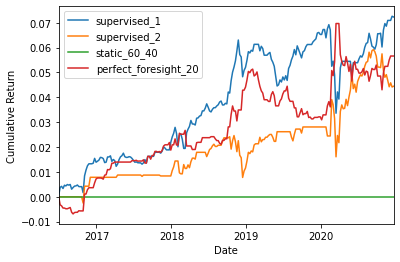

In [ ]:
fig, ax = plt.subplots()

for model_name in portfolio_returns.columns:
  ax.plot((portfolio_returns[model_name] - fund_weekly_returns.shift(-1)[:-1].aggregate(lambda x: tf_portfolio.initial_allocation[0]*x[0] + tf_portfolio.initial_allocation[1]*x[1], axis = 1).values).cumsum(), label=model_name)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax.margins(x=0)
ax.legend(loc='upper left')

plt.show()

## Model 1 Relative Performance Relative to Other Supservised Models

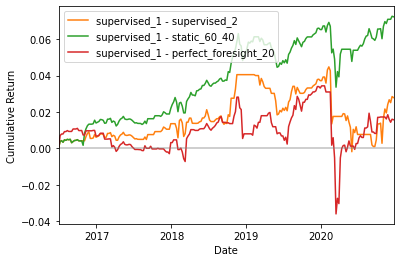

In [ ]:
fig, ax = plt.subplots()

ax.plot((portfolio_returns['supervised_1'] - portfolio_returns['supervised_2']).cumsum(), label='supervised_1 - supervised_2', color='#ff7f0e')
ax.plot((portfolio_returns['supervised_1'] - portfolio_returns['static_60_40']).cumsum(), label='supervised_1 - static_60_40', color='#2ca02c')
ax.plot((portfolio_returns['supervised_1'] - portfolio_returns['perfect_foresight_20']).cumsum(), label='supervised_1 - perfect_foresight_20', color='#d62728')

ax.axhline(y=0, color='grey', linestyle='-', alpha=0.5)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
ax.margins(x=0)
ax.legend(loc='upper left')

plt.show()

# Multi-armed Bandit Experiments

## Visualization Functions

In [ ]:
def plot_model_performance_model_actions(scores, bandit, agent, trial, returns_history, weighted_action_history, policy, epsilon):
    experiment_results = pd.DataFrame({'MAB Returns': scores}, index = bandit.action_values.index)
    trial_dates = pd.DataFrame(portfolio_returns.index.values, columns=['date'])

    strategy_names = ['supervised_1', 'supervised_2', 'static_60_40', 'perfect_foresight_20', 'naive_momentum']

    returns_history_df = pd.concat([trial_dates,pd.DataFrame(returns_history, columns=strategy_names)], axis = 1).set_index('date')
    mean_actions = pd.concat([trial_dates, pd.DataFrame(weighted_action_history, columns=strategy_names)], axis = 1).set_index('date')

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16, 5))

    if hasattr(policy, 'buffer'):
      buffer_string = ' - Buffer: ' + str(policy.buffer)
    else:
      buffer_string = ''
    
    fig.suptitle(policy.name + '\n' + 'Epsilon: ' + str(epsilon) + buffer_string + ' - Cumulative Return: ' + str(round(sum(scores), 4)), y=1.05)

    #Create MAB Relative Performance Chart
    ax1_returns = ax1.plot((returns_history_df.subtract(experiment_results.values, axis = 1).multiply(-1)).cumsum())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    ax1.axhline(y=0, color='grey', linestyle='-', alpha=0.5)
    ax1.set_ylabel('Cumulative Return')
    ax1.set_xlabel('Date')
    ax1.margins(x=0)
    ax1.set_title('Average Cumulative Return of MAB Relative to Underlying Models')
    ax1.legend(ax1_returns, returns_history_df.columns.values)

    #Create action count chart
    ax2_counts = ax2.plot(mean_actions.cumsum())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.set_ylabel('Count')
    ax2.set_xlabel('Date')
    ax2.margins(x=0)
    ax2.set_title('Average MAB Agent Action Count')
    ax2.legend(ax2_counts, returns_history_df.columns.values)

    plt.show()

## Experiment Framework

In [ ]:
def conductExperiment(n_experiments, n_trials, bandit, epsilons, policy, reward_type):

  experiment_dicts = []

  for epsilon in epsilons:
    policy.update_epsilon(epsilon)

    agent = MAB_Agent(bandit, policy)
    environment = MAB_environment_sharpe(bandit, agent, supervised_signals, tf_portfolio, reward_type)
    rewards, returns, rewards_history, returns_history, weighted_action_history = environment.run(n_trials, n_experiments)

    plot_model_performance_model_actions(returns, bandit, agent, n_trials, returns_history, weighted_action_history, policy, epsilon)

    experiment_dict = {'agent': agent,
                       'environment': environment,
                       'rewards': rewards,
                       'returns': returns,
                       'rewards_history': rewards_history,
                       'returns_history': returns_history,
                       'weighted_action_history': weighted_action_history,
                       'policy': policy}

    experiment_dicts.append(experiment_dict)

  return experiment_dicts

## MAB Relative Performance to Supervised Models - Profit and Loss Reward

Setting number of experiments and trials (time steps, max 234)

In [ ]:
n_experiments = 10
n_trials = 234

print('Number of experiments: ' + str(n_experiments))
print('Number of trials: ' + str(n_trials))

Number of experiments: 10
Number of trials: 234


Define Multi-armed Bandit and Epsilons to Iterate Over

In [ ]:
bandit = MAB_WeeklyReturnsStdevs(portfolio_returns, supervised_signals, 'pl')

epsilons = [0, 0.10, 0.20, 0.30, 0.40]

### Epsilon-Greedy

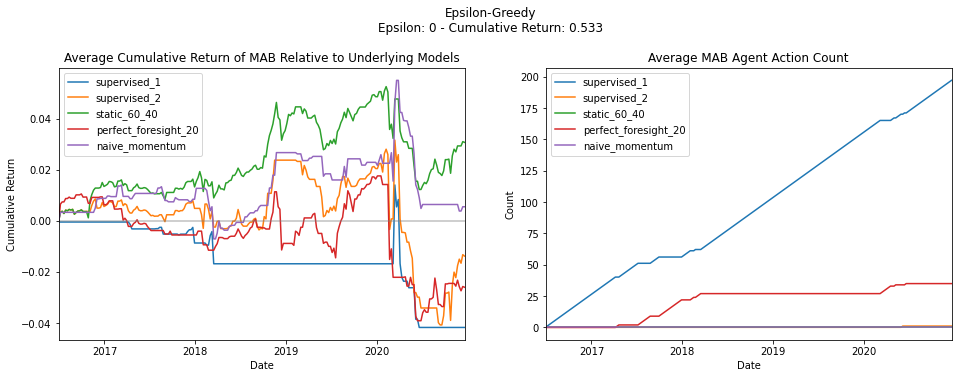

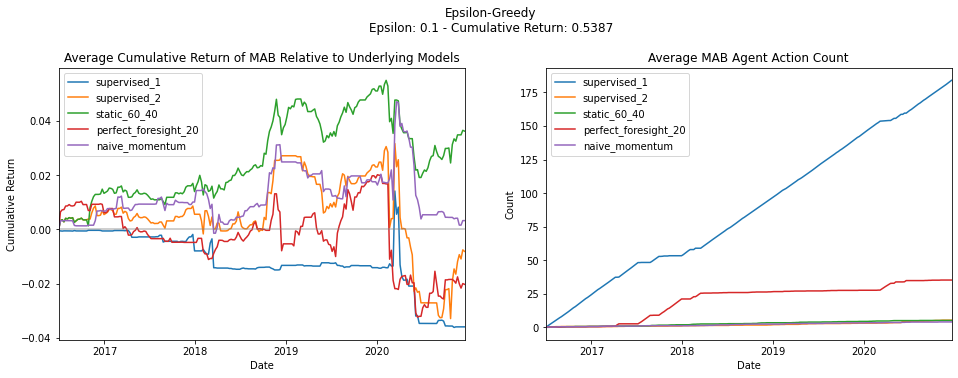

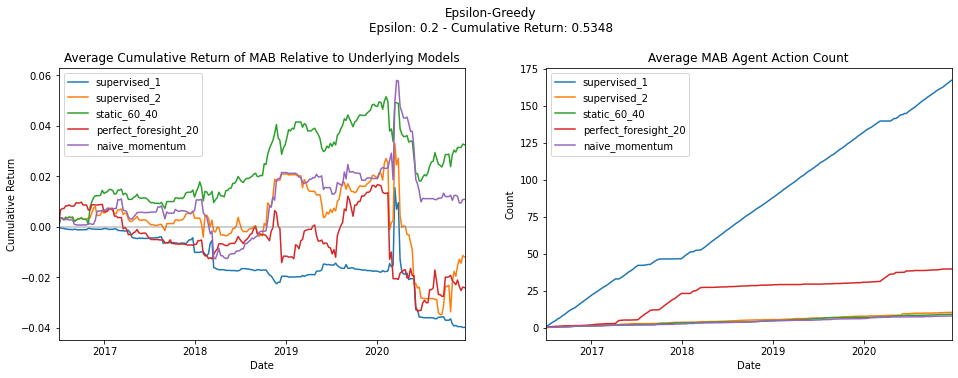

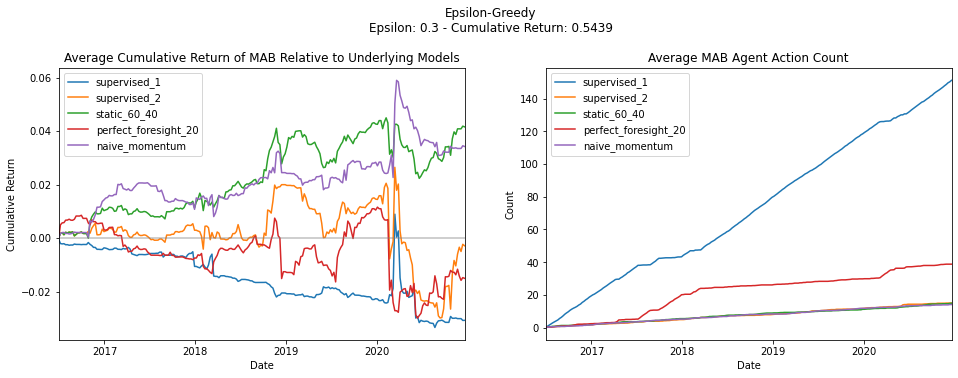

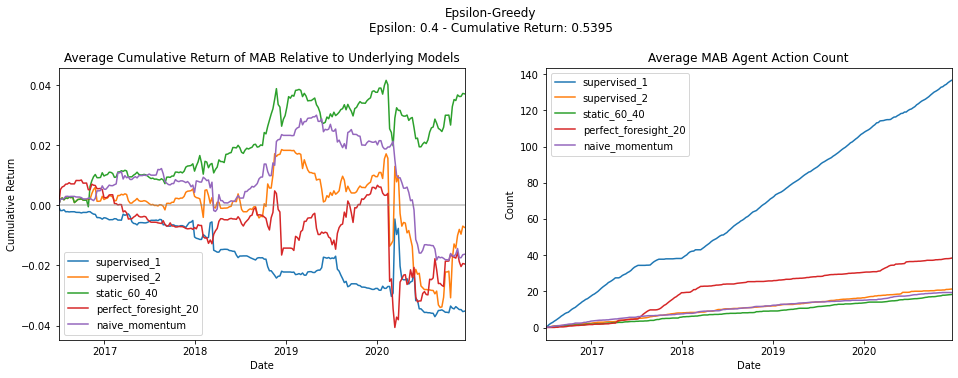

In [ ]:
policy = epsilonGreedy(0)

eg_pl_experiment_dicts = conductExperiment(n_experiments, n_trials, bandit, epsilons, policy, 'pl')

### Decayed Epsilon-Greedy

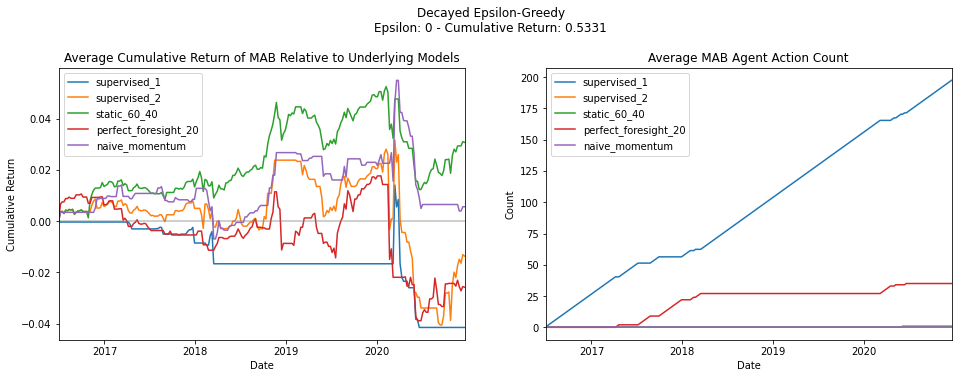

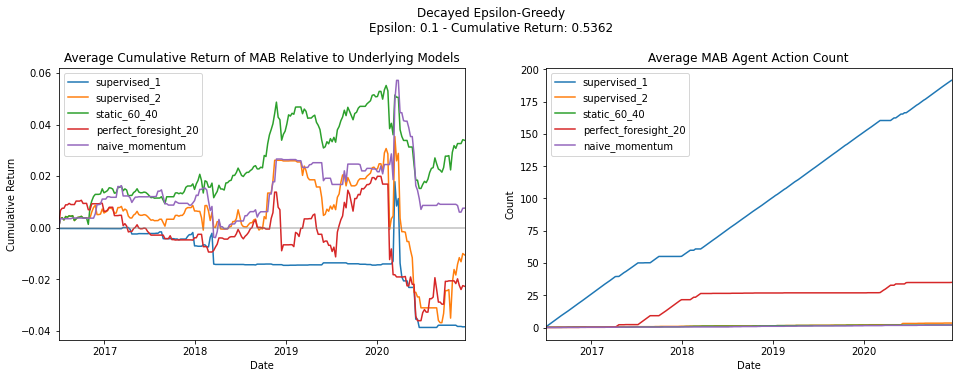

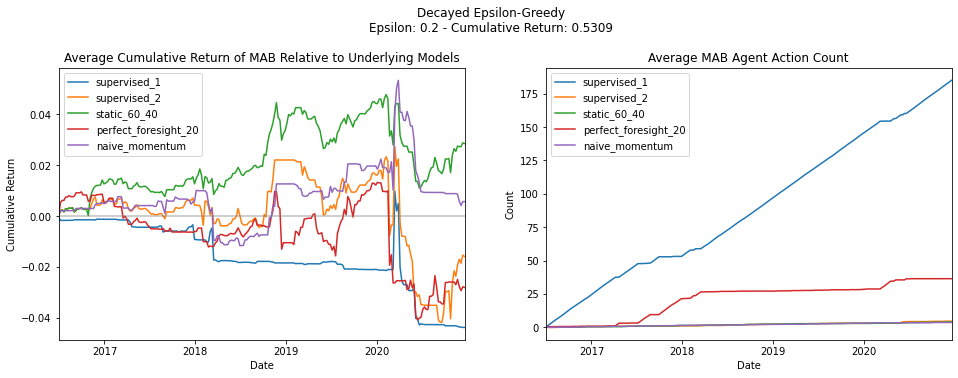

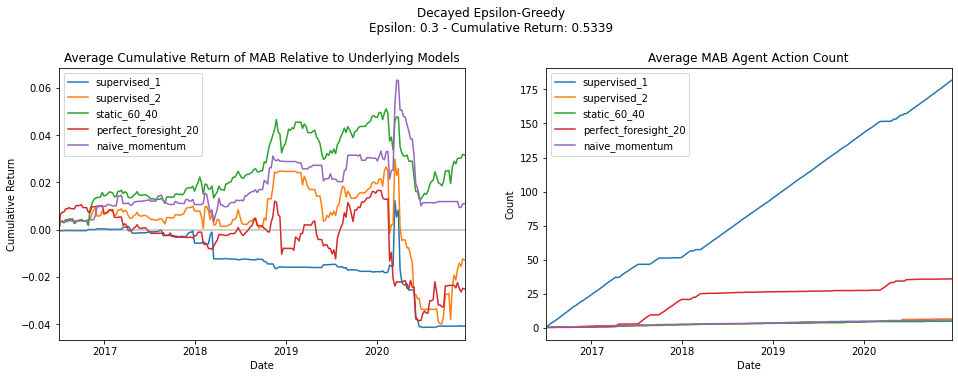

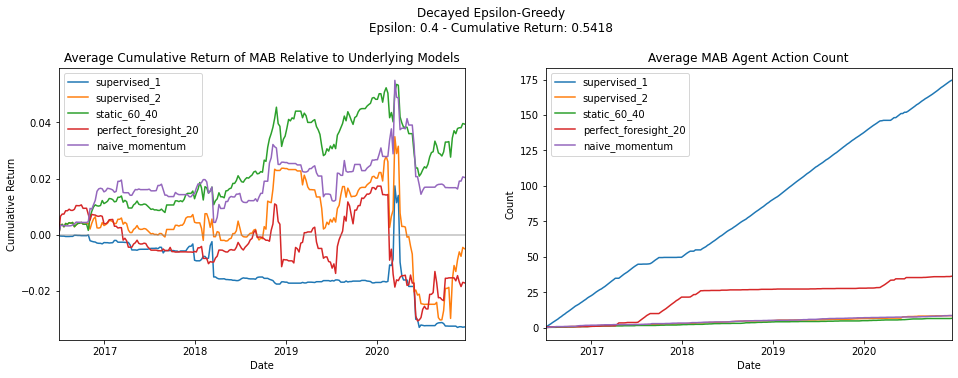

In [ ]:
min_epsilon = 0.01
epsilon_decay = 0.999

policy = epsilonGreedyDecay(0, min_epsilon, epsilon_decay)

deg_pl_experiment_dicts = conductExperiment(n_experiments, n_trials, bandit, epsilons, policy, 'pl')

### Non-stationary Buffered Epsilon-Greedy #1

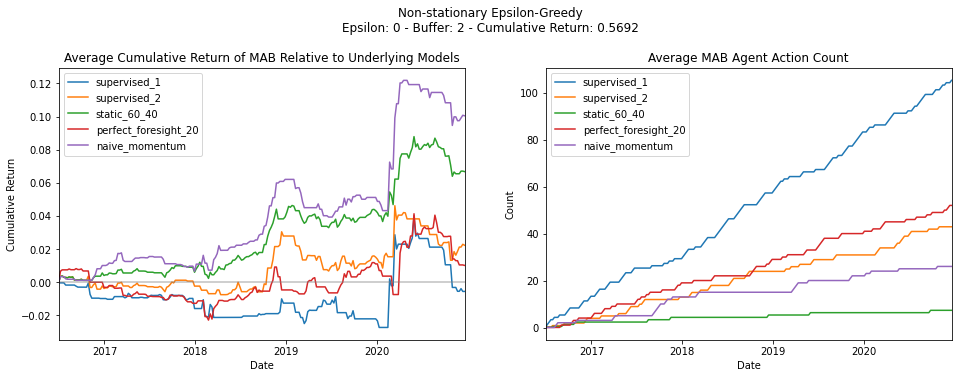

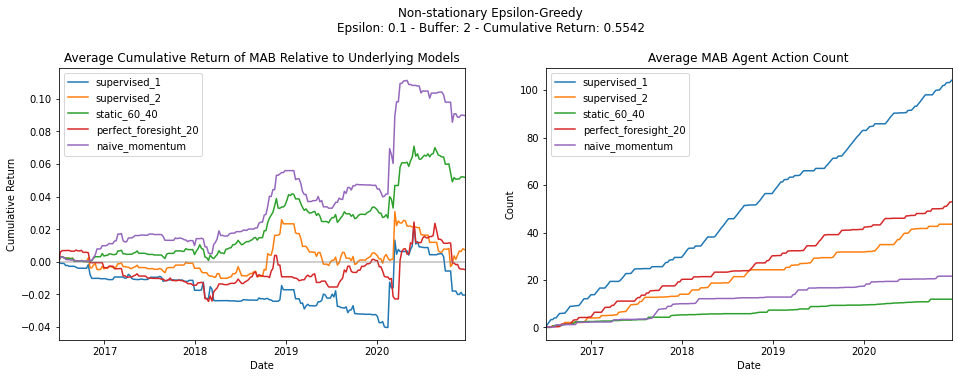

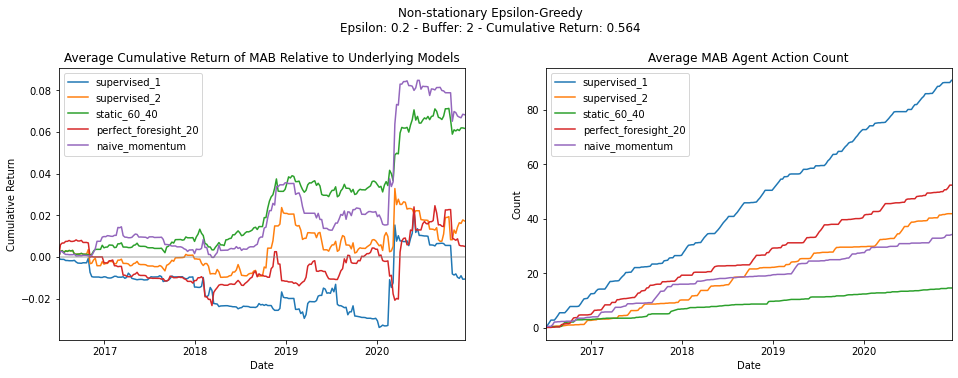

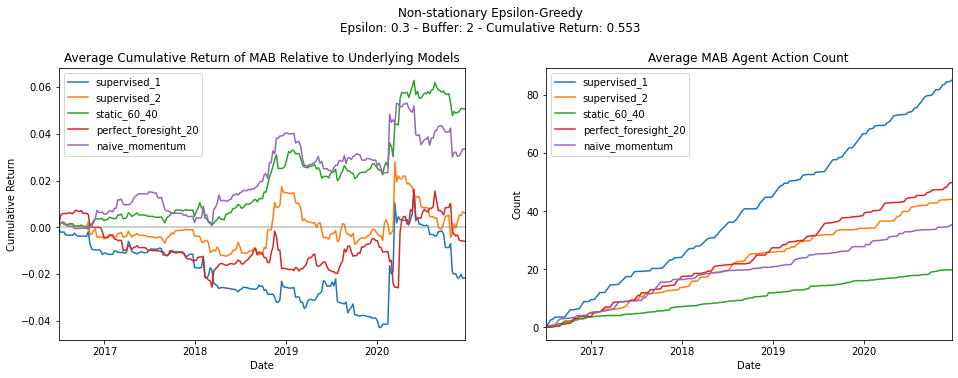

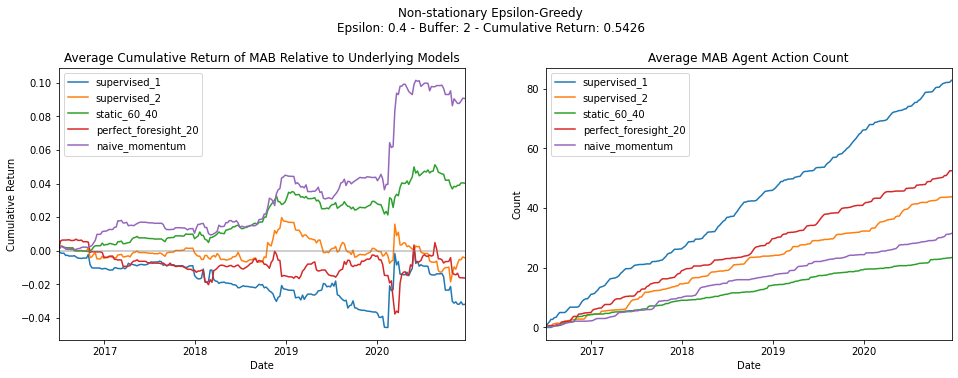

In [ ]:
buffer = 2

policy = NSepsilonGreedy(0, buffer)

nseg_pl_experiment_dicts1 = conductExperiment(n_experiments, n_trials, bandit, epsilons, policy, 'pl')

### Non-stationary Buffered Epsilon-Greedy #2

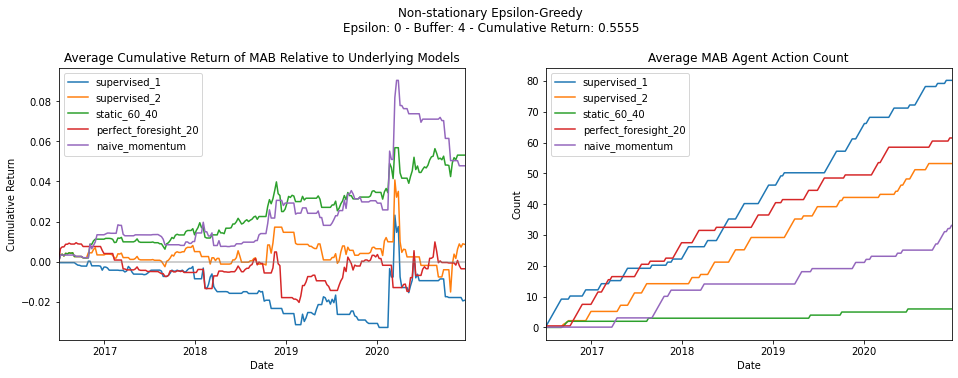

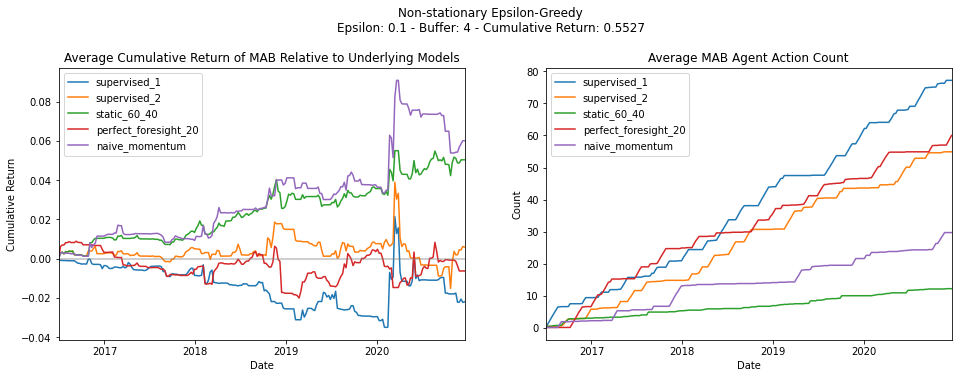

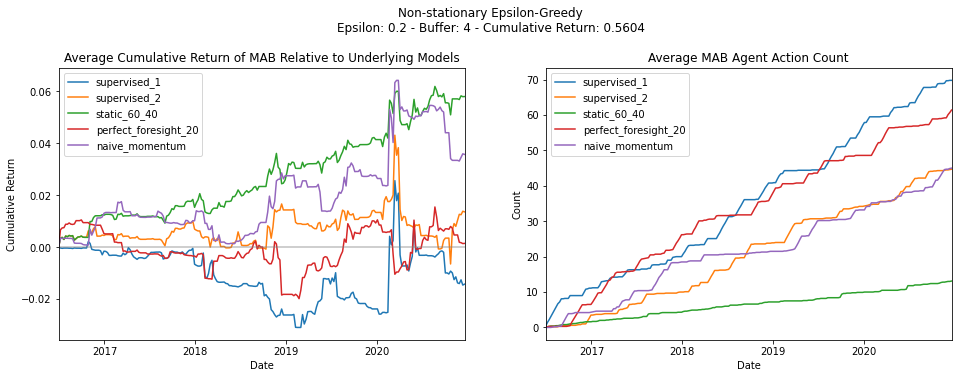

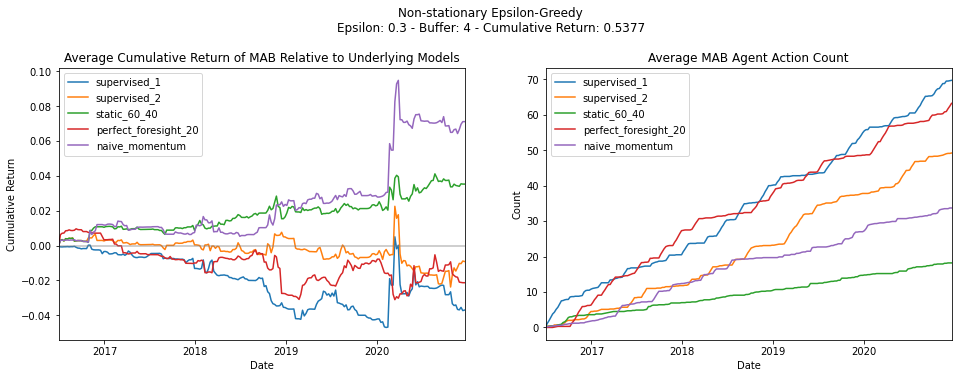

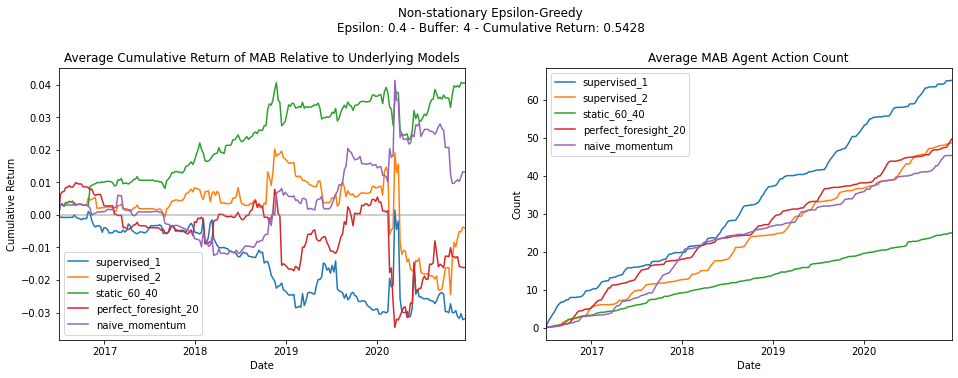

In [ ]:
buffer = 4

policy = NSepsilonGreedy(0, buffer)

nseg_pl_experiment_dicts2 = conductExperiment(n_experiments, n_trials, bandit, epsilons, policy, 'pl')

### Non-stationary EWM Epsilon-Greedy

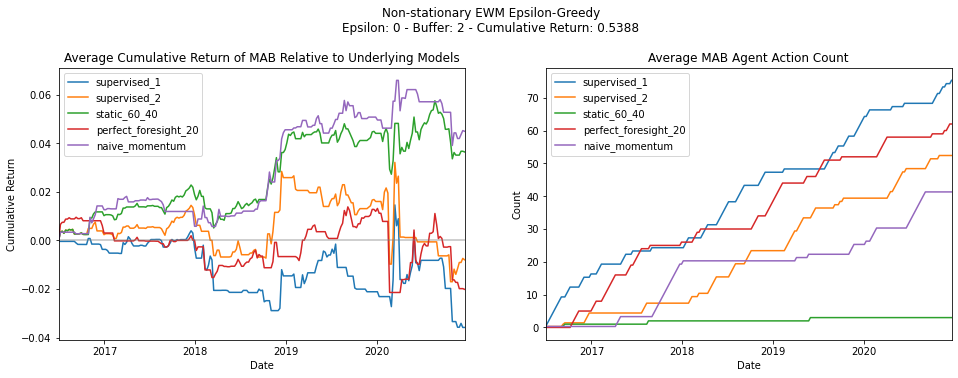

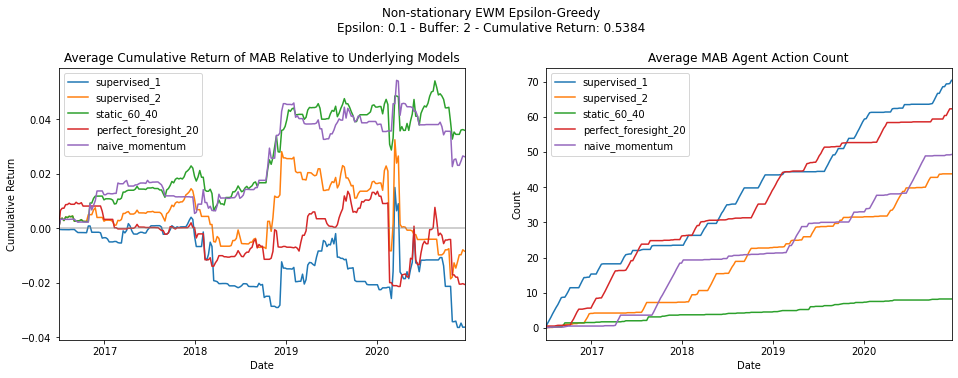

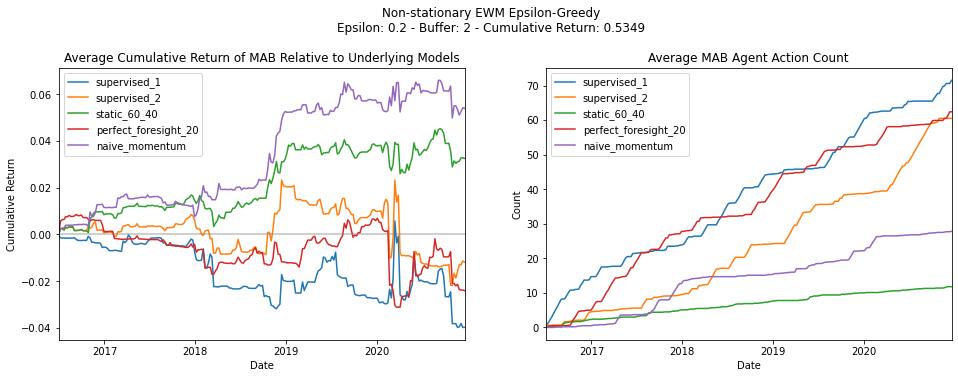

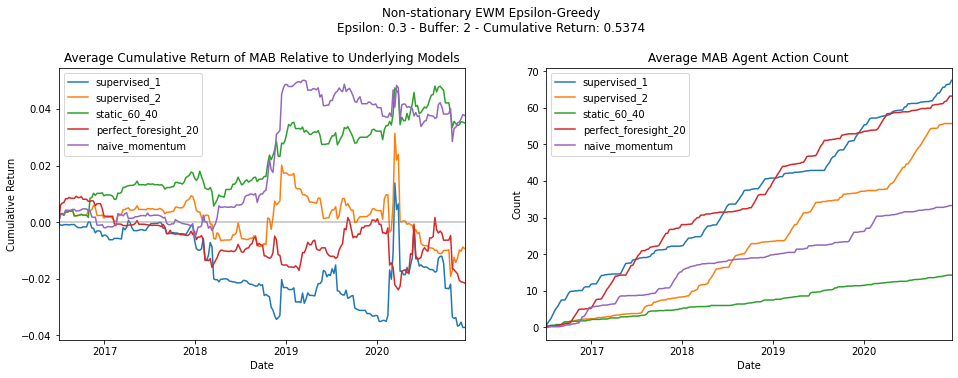

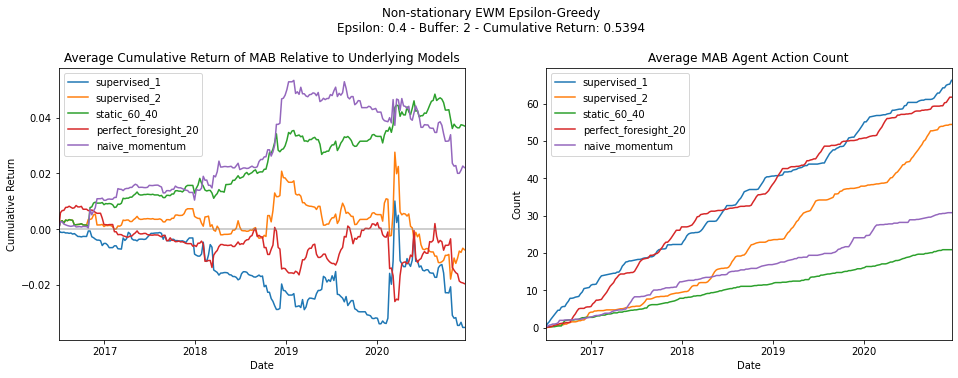

In [ ]:
buffer = 2

policy = NSDepsilonGreedy(0, buffer)

nsdeg_pl_experiment_dicts = conductExperiment(n_experiments, n_trials, bandit, epsilons, policy, 'pl')

### MAB Policy Comparison - Profit and Loss

In [ ]:
policy_comparison_df = pd.DataFrame(columns=['Policy', 'Return', 'Standard Deviation', 'Sharpe Ratio'])

exp_policies = [eg_pl_experiment_dicts, deg_pl_experiment_dicts, nseg_pl_experiment_dicts1, nseg_pl_experiment_dicts2, nsdeg_pl_experiment_dicts]

for exp_policy in exp_policies:
  return_sum = sum(exp_policy[0]['returns'])
  return_std = np.std(exp_policy[0]['returns'])
  
  if hasattr(exp_policy[0]['policy'], 'buffer'):
      buffer_string = ' - Buffer: ' + str(exp_policy[0]['policy'].buffer)
  else:
      buffer_string = ''

  df_entry = {'Policy': exp_policy[0]['policy'].name + buffer_string, 'Return': return_sum, 'Standard Deviation': return_std, 'Sharpe Ratio': return_sum/return_std}

  policy_comparison_df = policy_comparison_df.append(df_entry, ignore_index=True)

round(policy_comparison_df,4)

Policy  Return  Standard Deviation  \
0                                 Epsilon-Greedy  0.5330              0.0154   
1                         Decayed Epsilon-Greedy  0.5331              0.0154   
2      Non-stationary Epsilon-Greedy - Buffer: 2  0.5692              0.0149   
3      Non-stationary Epsilon-Greedy - Buffer: 4  0.5555              0.0147   
4  Non-stationary EWM Epsilon-Greedy - Buffer: 2  0.5388              0.0149   

   Sharpe Ratio  
0       34.6982  
1       34.7048  
2       38.0894  
3       37.7045  
4       36.2540

## MAB Relative Performance to Supervised Models - Sharpe Reward

Setting number of experiments and trials (time steps, max 234)

In [ ]:
n_experiments = 10
n_trials = 234

print('Number of experiments: ' + str(n_experiments))
print('Number of trials: ' + str(n_trials))

Number of experiments: 10
Number of trials: 234


Define Multi-armed Bandit and Epsilons to Iterate Over

In [ ]:
bandit_sharpe = MAB_WeeklyReturnsStdevs(portfolio_returns, supervised_signals, 'sharpe')

epsilons = [0, 0.10, 0.20, 0.30, 0.40]

### Epsilon-Greedy

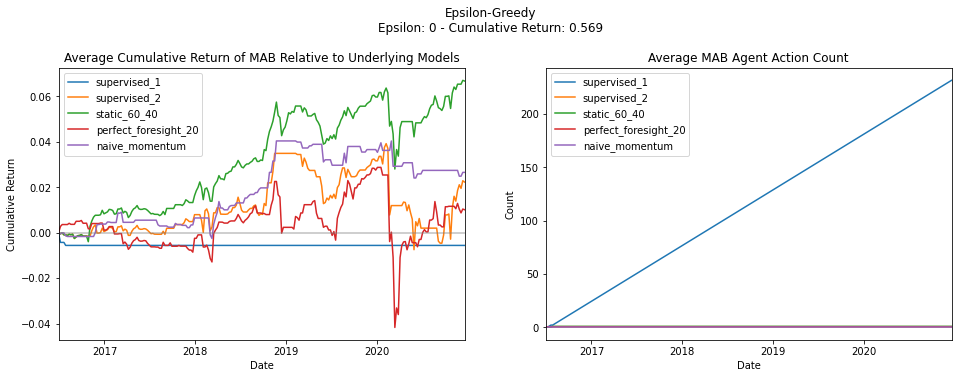

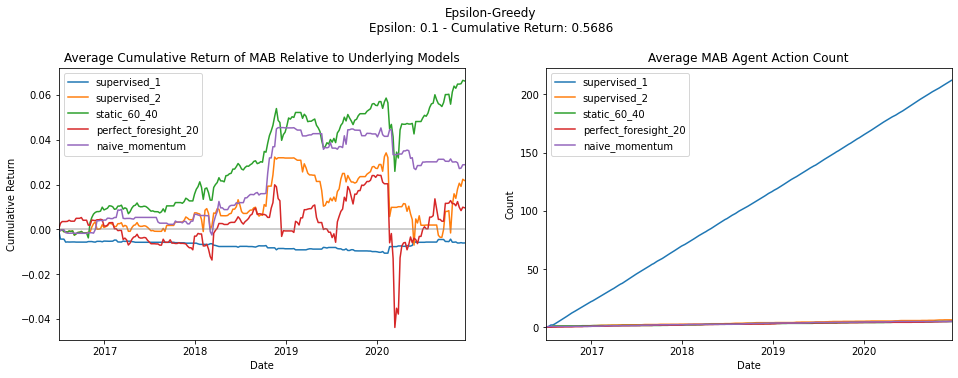

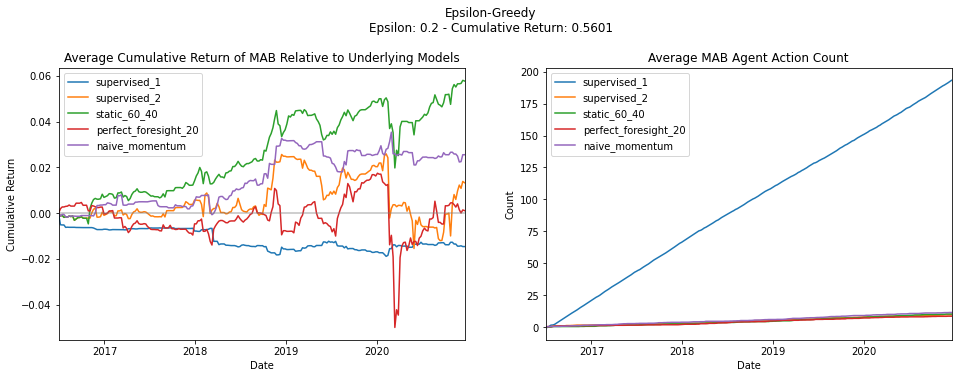

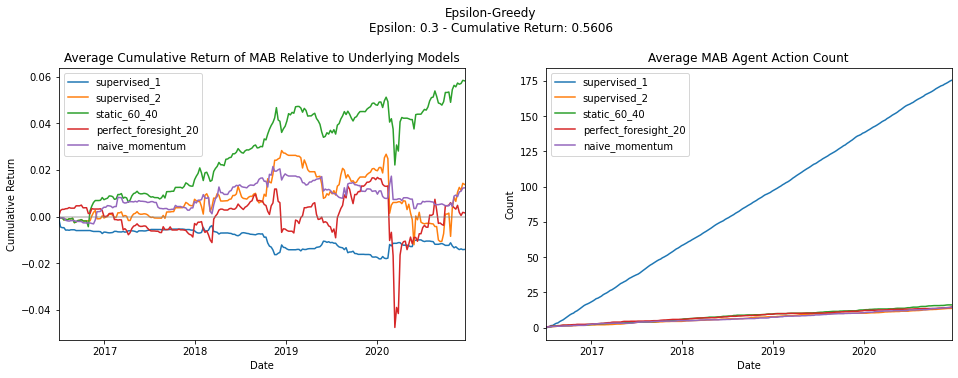

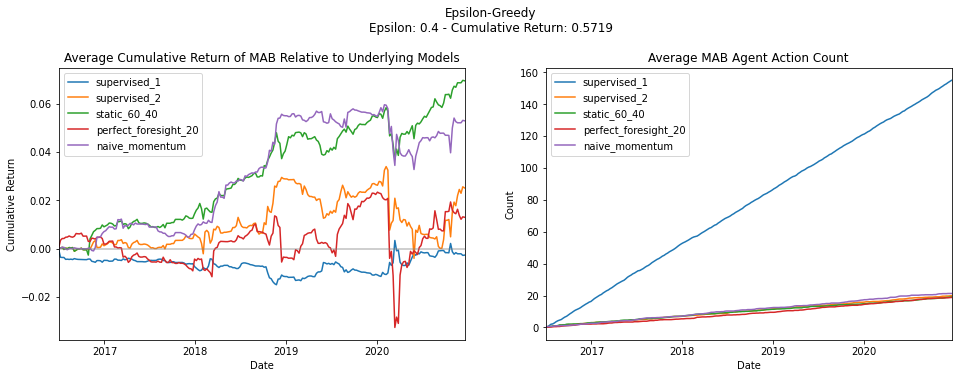

In [ ]:
policy = epsilonGreedy(0)

eg_sharpe_experiment_dicts = conductExperiment(n_experiments, n_trials, bandit_sharpe, epsilons, policy, 'sharpe')

### Decayed Epsilon-Greedy

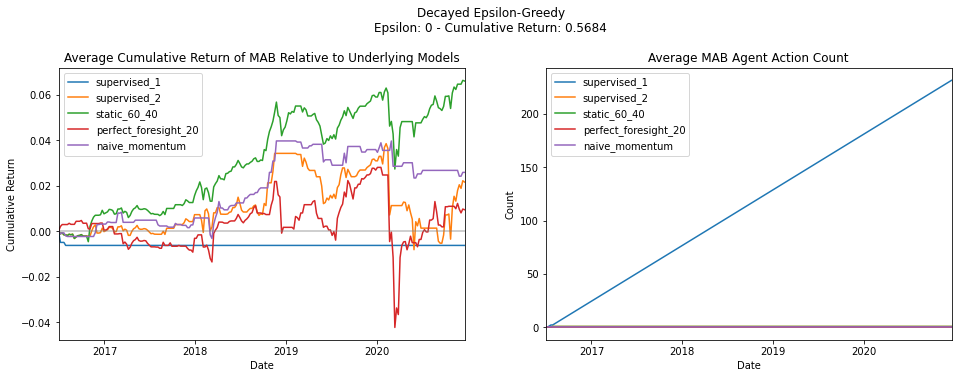

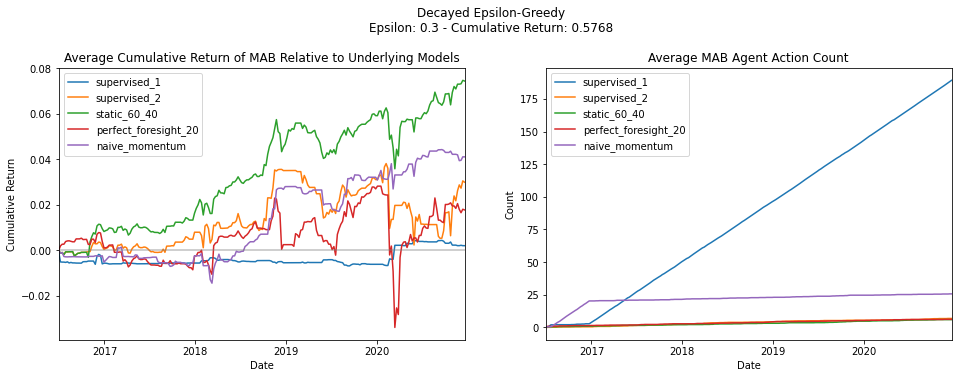

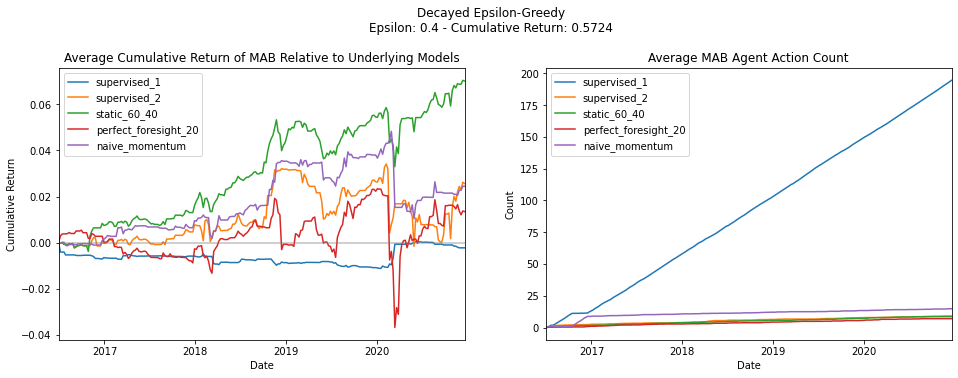

In [ ]:
min_epsilon = 0.01
epsilon_decay = 0.999

policy = epsilonGreedyDecay(0, min_epsilon, epsilon_decay)

deg_sharpe_experiment_dicts = conductExperiment(n_experiments, n_trials, bandit_sharpe, epsilons, policy, 'sharpe')

### Non-stationary Buffered Epsilon-Greedy #1

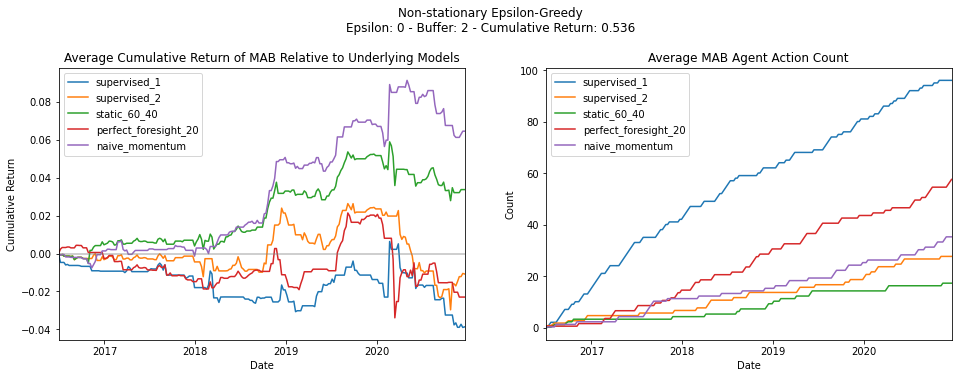

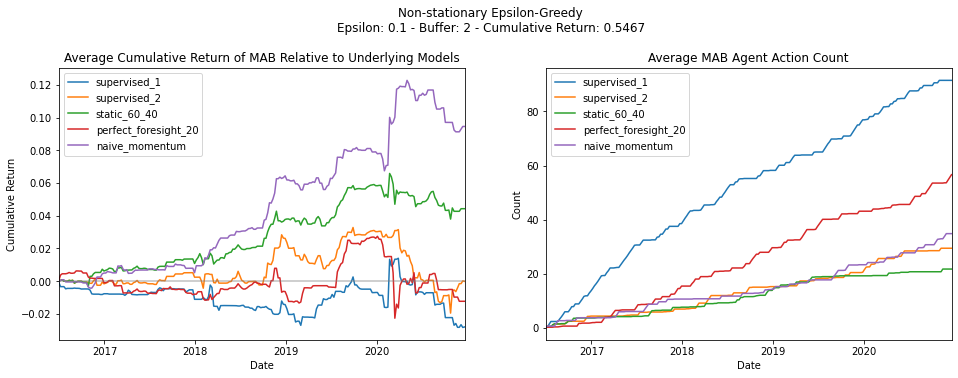

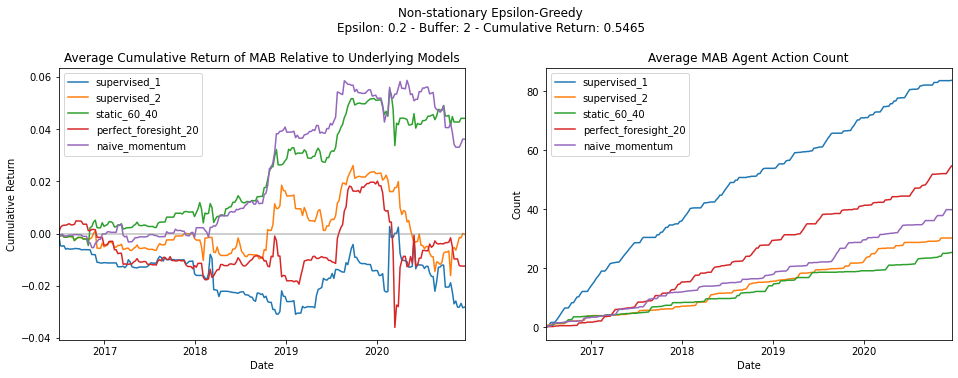

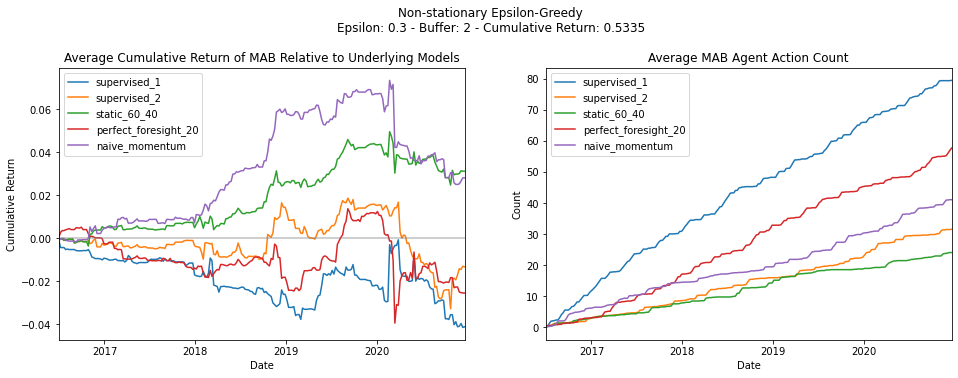

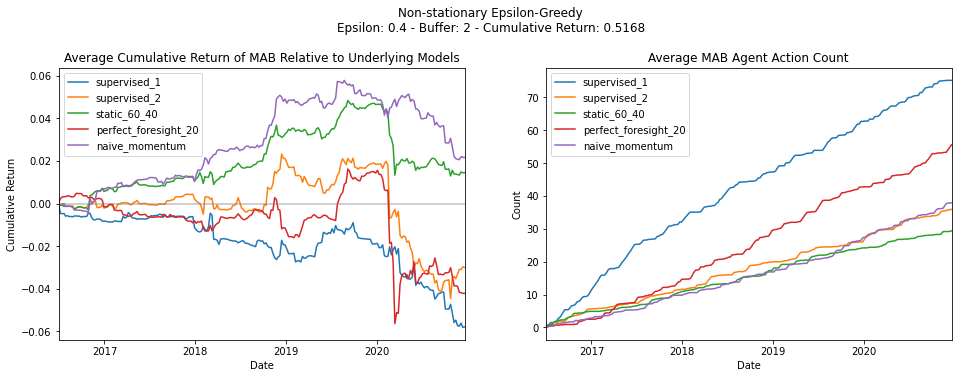

In [ ]:
buffer = 2

policy = NSepsilonGreedy(0, buffer)

nseg_sharpe_experiment_dicts1 = conductExperiment(n_experiments, n_trials, bandit_sharpe, epsilons, policy, 'sharpe')

### Non-stationary Buffered Epsilon-Greedy #2

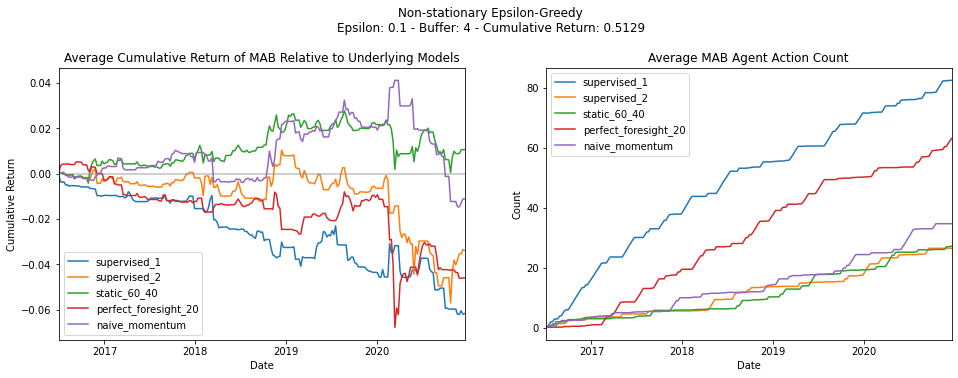

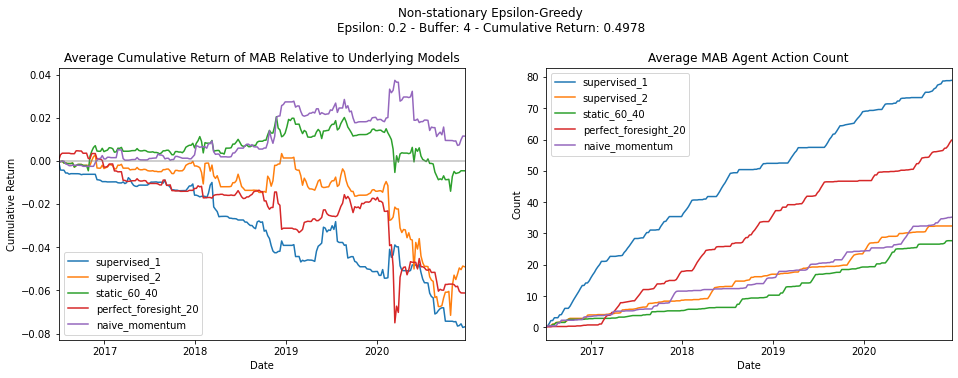

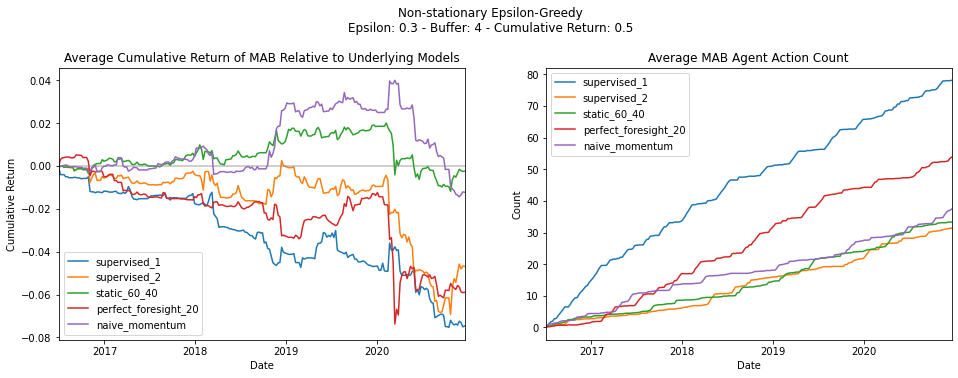

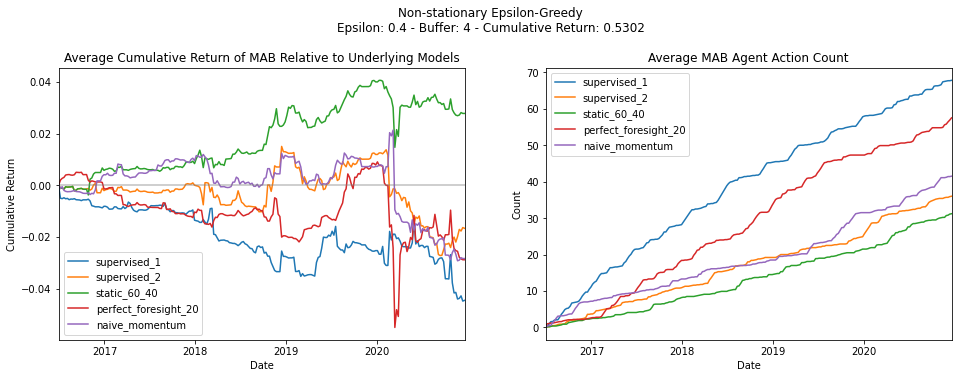

In [ ]:
buffer = 4

policy = NSepsilonGreedy(0, buffer)

nsdeg_sharpe_experiment_dicts2 = conductExperiment(n_experiments, n_trials, bandit_sharpe, epsilons, policy, 'sharpe')

### Non-stationary EWM Epsilon-Greedy

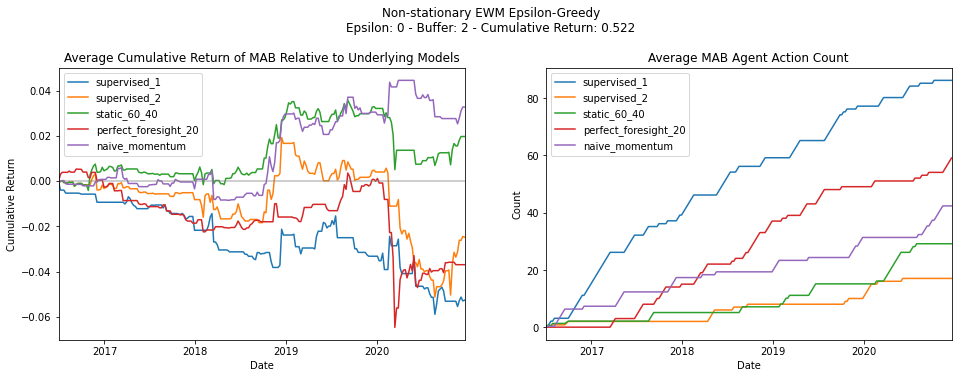

In [ ]:
buffer = 2

policy = NSDepsilonGreedy(0, buffer)

nsdeg_sharpe_experiment_dicts = conductExperiment(n_experiments, n_trials, bandit_sharpe, epsilons, policy, 'sharpe')

### MAB Policy Comparison - Sharpe

In [ ]:
policy_comparison_df = pd.DataFrame(columns=['Policy', 'Return', 'Standard Deviation', 'Sharpe Ratio'])

exp_policies = [eg_sharpe_experiment_dicts, deg_sharpe_experiment_dicts, nseg_sharpe_experiment_dicts1, nsdeg_sharpe_experiment_dicts2, nsdeg_sharpe_experiment_dicts]

for exp_policy in exp_policies:
  return_sum = sum(exp_policy[0]['returns'])
  return_std = np.std(exp_policy[0]['returns'])
  
  if hasattr(exp_policy[0]['policy'], 'buffer'):
      buffer_string = ' - Buffer: ' + str(exp_policy[0]['policy'].buffer)
  else:
      buffer_string = ''

  df_entry = {'Policy': exp_policy[0]['policy'].name + buffer_string, 'Return': return_sum, 'Standard Deviation': return_std, 'Sharpe Ratio': return_sum/return_std}

  policy_comparison_df = policy_comparison_df.append(df_entry, ignore_index=True)

round(policy_comparison_df,4)

Policy  Return  Standard Deviation  \
0                                 Epsilon-Greedy  0.5690              0.0165   
1                         Decayed Epsilon-Greedy  0.5684              0.0165   
2      Non-stationary Epsilon-Greedy - Buffer: 2  0.5360              0.0157   
3      Non-stationary Epsilon-Greedy - Buffer: 4  0.5061              0.0159   
4  Non-stationary EWM Epsilon-Greedy - Buffer: 2  0.5220              0.0159   

   Sharpe Ratio  
0       34.4254  
1       34.3889  
2       34.0607  
3       31.7506  
4       32.9304